In [1]:
import pandas as pd

df = pd.read_csv("la_o3_1000points.csv")
df.head()


,timestamp,o3_ug_m3
0,2023-10-06 03:00:00+00:00,52.92
1,2023-10-06 04:00:00+00:00,29.40
2,2023-10-06 05:00:00+00:00,19.60
3,2023-10-06 06:00:00+00:00,5.88
4,2023-10-06 07:00:00+00:00,11.76


In [2]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df.set_index('timestamp')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2023-10-06 03:00:00+00:00 to 2023-11-17 07:00:00+00:00
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   o3_ug_m3  1000 non-null   float64
dtypes: float64(1)
memory usage: 15.6 KB


,o3_ug_m3
timestamp,
2023-10-06 03:00:00+00:00,52.92
2023-10-06 04:00:00+00:00,29.40
2023-10-06 05:00:00+00:00,19.60
2023-10-06 06:00:00+00:00,5.88
2023-10-06 07:00:00+00:00,11.76


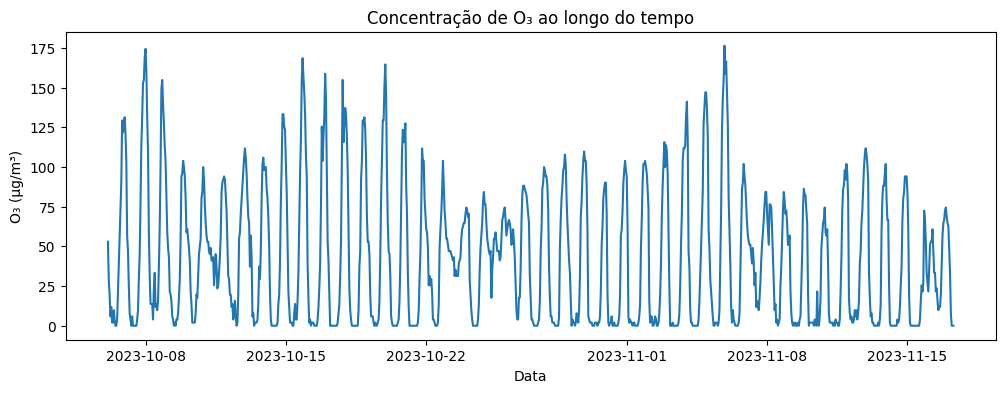

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(df.index, df['o3_ug_m3'])
plt.title('Concentração de O₃ ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('O₃ (µg/m³)')
plt.show()


In [4]:
print(df['o3_ug_m3'].describe())

print(df.isna().sum())


count    1000.00000
mean       42.90244
std        42.81808
min         0.00000
25%         1.96000
50%        33.32000
75%        72.52000
max       176.40000
Name: o3_ug_m3, dtype: float64
o3_ug_m3    0
dtype: int64


timestamp
0 days 01:00:00    991
0 days 02:00:00      6
0 days 05:00:00      1
0 days 04:00:00      1
Name: count, dtype: int64


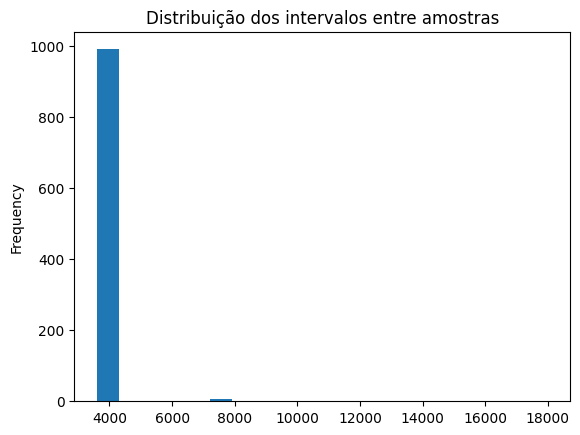

In [5]:
intervalos = df.index.to_series().diff().dropna()
print(intervalos.value_counts().head())

intervalos.dt.total_seconds().plot(kind='hist', bins=20, title='Distribuição dos intervalos entre amostras')
plt.show()

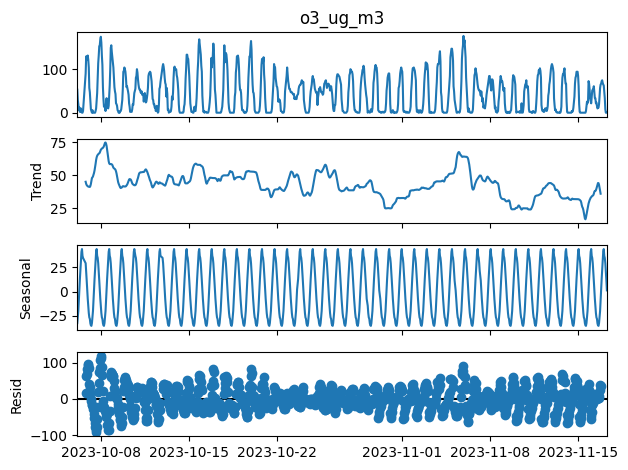

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['o3_ug_m3'], model='additive', period=24)
result.plot()
plt.show()


In [7]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['o3_ug_m3'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")


ADF Statistic: -3.03585571975386
p-value: 0.03167891044827406


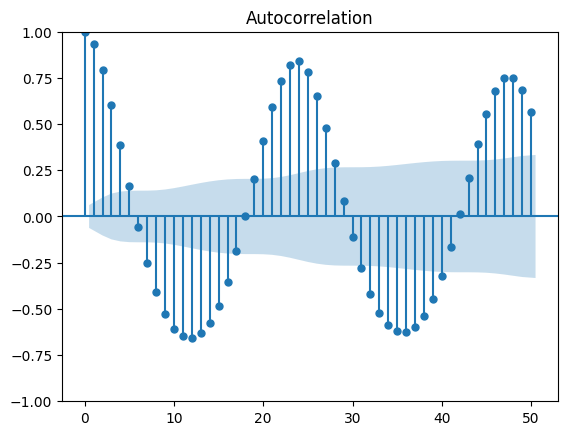

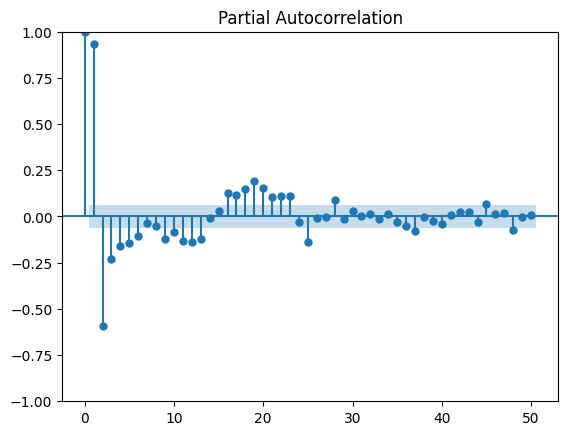

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['o3_ug_m3'], lags=50)
plt.show()

plot_pacf(df['o3_ug_m3'], lags=50)
plt.show()


the series is non-stationary, but with a very well-defined daily seasonality.

# Preparing the data

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

df = pd.read_csv("la_o3_1000points.csv", parse_dates=['timestamp'])
df = df.set_index('timestamp')

train = df.iloc[:-48]
test = df.iloc[-48:]

In [10]:
print(f"Tamanho treino: {len(train)} | Tamanho teste: {len(test)}")

Tamanho treino: 952 | Tamanho teste: 48


## SARIMA

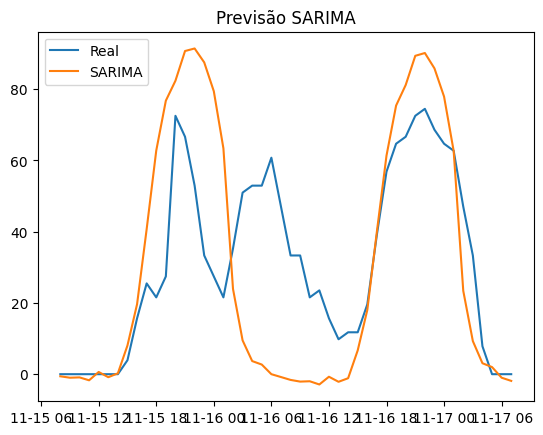

SARIMA -> MAE: 19.17 | RMSE: 26.45


In [11]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(train['o3_ug_m3'],
                       order=(1,1,1),
                       seasonal_order=(1,1,1,24),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_fit = model_sarima.fit(disp=False)

sarima_pred = sarima_fit.forecast(steps=48)
plt.plot(test.index, test['o3_ug_m3'], label='Real')
plt.plot(test.index, sarima_pred, label='SARIMA')
plt.legend()
plt.title('Previsão SARIMA')
plt.show()

sarima_mae = mean_absolute_error(test['o3_ug_m3'], sarima_pred)
sarima_rmse = np.sqrt(mean_squared_error(test['o3_ug_m3'], sarima_pred))
print(f"SARIMA -> MAE: {sarima_mae:.2f} | RMSE: {sarima_rmse:.2f}")


## Hot wilters

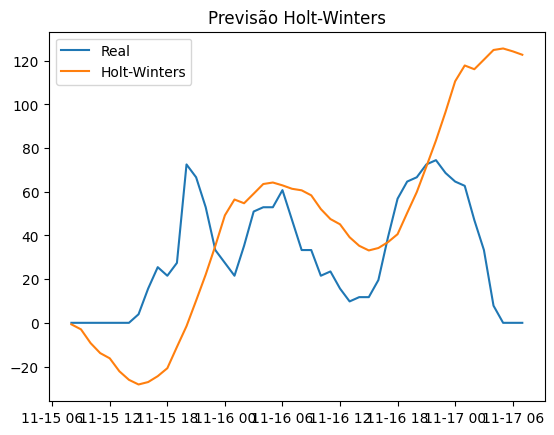

Holt-Winters -> MAE: 34.02 | RMSE: 47.28


In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_hw = ExponentialSmoothing(train['o3_ug_m3'],
                                trend='add',
                                seasonal='add',
                                seasonal_periods=24)
hw_fit = model_hw.fit()
hw_pred = hw_fit.forecast(48)

plt.plot(test.index, test['o3_ug_m3'], label='Real')
plt.plot(test.index, hw_pred, label='Holt-Winters')
plt.legend()
plt.title('Previsão Holt-Winters')
plt.show()

hw_mae = mean_absolute_error(test['o3_ug_m3'], hw_pred)
hw_rmse = np.sqrt(mean_squared_error(test['o3_ug_m3'], hw_pred))
print(f"Holt-Winters -> MAE: {hw_mae:.2f} | RMSE: {hw_rmse:.2f}")


## Prophet

12:36:40 - cmdstanpy - INFO - Chain [1] start processing
12:36:41 - cmdstanpy - INFO - Chain [1] done processing


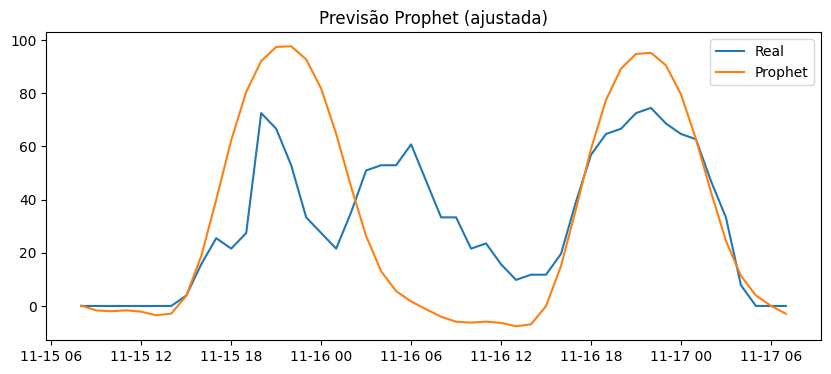

Prophet -> MAE: 19.96 | RMSE: 27.03


In [13]:
from prophet import Prophet

train_no_tz = train.copy()
train_no_tz.index = train_no_tz.index.tz_localize(None)

test_no_tz = test.copy()
test_no_tz.index = test_no_tz.index.tz_localize(None)

df_prophet = train_no_tz.reset_index().rename(columns={'timestamp': 'ds', 'o3_ug_m3': 'y'})

model_prophet = Prophet(daily_seasonality=True, weekly_seasonality=True)
model_prophet.fit(df_prophet)

future = pd.DataFrame({'ds': test_no_tz.index})
forecast = model_prophet.predict(future)

plt.figure(figsize=(10,4))
plt.plot(test_no_tz.index, test_no_tz['o3_ug_m3'], label='Real')
plt.plot(test_no_tz.index, forecast['yhat'], label='Prophet')
plt.legend()
plt.title('Previsão Prophet (ajustada)')
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

prophet_mae = mean_absolute_error(test_no_tz['o3_ug_m3'], forecast['yhat'])
prophet_rmse = np.sqrt(mean_squared_error(test_no_tz['o3_ug_m3'], forecast['yhat']))
print(f"Prophet -> MAE: {prophet_mae:.2f} | RMSE: {prophet_rmse:.2f}")


:(

## Random Forest

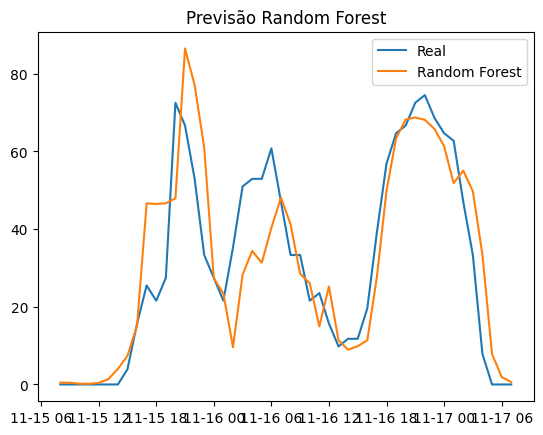

Random Forest -> MAE: 9.23 | RMSE: 12.91


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

def create_lag_features(data, lags=24):
    df_lag = data.copy()
    for lag in range(1, lags+1):
        df_lag[f'lag_{lag}'] = df_lag['o3_ug_m3'].shift(lag)
    df_lag = df_lag.dropna()
    return df_lag

df_lag = create_lag_features(df)
train_lag = df_lag.iloc[:-48]
test_lag = df_lag.iloc[-48:]

X_train = train_lag.drop('o3_ug_m3', axis=1)
y_train = train_lag['o3_ug_m3']
X_test = test_lag.drop('o3_ug_m3', axis=1)
y_test = test_lag['o3_ug_m3']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)

plt.plot(test.index, y_test, label='Real')
plt.plot(test.index, rf_pred, label='Random Forest')
plt.legend()
plt.title('Previsão Random Forest')
plt.show()

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
print(f"Random Forest -> MAE: {rf_mae:.2f} | RMSE: {rf_rmse:.2f}")


:/

## Compare

In [15]:
results = pd.DataFrame({
    'Modelo': ['SARIMA', 'Holt-Winters', 'Prophet', 'Random Forest'],
    'MAE': [sarima_mae, hw_mae, prophet_mae, rf_mae],
    'RMSE': [sarima_rmse, hw_rmse, prophet_rmse, rf_rmse]
})
print(results.sort_values('RMSE'))


          Modelo        MAE       RMSE
3  Random Forest   9.233642  12.910035
0         SARIMA  19.169652  26.445081
2        Prophet  19.957386  27.031588
1   Holt-Winters  34.020366  47.283533


In [16]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import joblib

LAGS = 24
MODEL_PATH = "rf_o3_pipeline.joblib"

def create_lag_features(series: pd.Series, lags: int = LAGS) -> pd.DataFrame:
    """Cria colunas lag_1..lag_LAGS e retorna dataframe alinhado (sem NaN)."""
    df_lag = pd.DataFrame({"o3_ug_m3": series})
    for lag in range(1, lags + 1):
        df_lag[f"lag_{lag}"] = df_lag["o3_ug_m3"].shift(lag)
    return df_lag.dropna()

# --- Carregue seu dataset (ajuste o caminho do arquivo) ---
df = pd.read_csv("la_o3_1000points.csv", parse_dates=["timestamp"])
df = df.set_index("timestamp").sort_index()

# (opcional) Remover timezone, se houver
if df.index.tz is not None:
    df.index = df.index.tz_localize(None)

# Cria features de defasagem e treina em TODO o histórico disponível
df_lag = create_lag_features(df["o3_ug_m3"], lags=LAGS)
X = df_lag.drop(columns=["o3_ug_m3"]).values
y = df_lag["o3_ug_m3"].values

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])
pipe.fit(X, y)

# Salva o pipeline na pasta atual
joblib.dump(pipe, MODEL_PATH)
print(f"Modelo salvo em: {MODEL_PATH} (treinado com {len(y)} amostras)")


Modelo salvo em: rf_o3_pipeline.joblib (treinado com 976 amostras)


# Função de uso final

In [ ]:
import io
import pandas as pd
import numpy as np
import joblib

LAGS = 24
MODEL_PATH = "rf_o3_pipeline.joblib"

def _load_csv(csv_input):
    """Aceita caminho de arquivo ou string CSV; retorna DataFrame com índice datetime."""
    if isinstance(csv_input, str) and "\n" in csv_input:
        df = pd.read_csv(io.StringIO(csv_input), parse_dates=["timestamp"])
    else:
        df = pd.read_csv(csv_input, parse_dates=["timestamp"])
    df = df.set_index("timestamp").sort_index()
    if df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    return df

def predict_next_24_from_csv(csv_input, model_path: str = MODEL_PATH, decimals: int = 2):
    """
    Lê o csv (arquivo ou string), carrega o modelo salvo e gera 24 previsões futuras.
    Retorna apenas a string 'v1,v2,...,v24' com os valores arredondados.
    """
    # Carregar dados
    df = _load_csv(csv_input)
    series = df["o3_ug_m3"].astype(float).copy()

    if len(series) < LAGS:
        raise ValueError(f"São necessários pelo menos {LAGS} pontos para iniciar a previsão.")

    # Carregar pipeline treinado
    pipe = joblib.load(model_path)

    # Semente inicial: últimos 24 valores observados
    window = list(series.iloc[-LAGS:].values)
    preds = []

    # Previsão iterativa (multi-step) 24 passos à frente
    for _ in range(24):
        # Monta [lag_1..lag_24] com base na janela atual (lag_1 = último valor)
        features = np.array(window[::-1])  # inverte: último vira lag_1
        features = features.reshape(1, -1)
        y_hat = float(pipe.predict(features)[0])
        preds.append(y_hat)

        # Atualiza janela para próxima iteração
        window.append(y_hat)
        window = window[-LAGS:]

    # Formatação: "v1,v2,...,v24" com N casas decimais
    fmt = f"{{:.{decimals}f}}"
    out = ",".join(fmt.format(v) for v in preds)
    return out


In [18]:
preds_str = predict_next_24_from_csv("la_o3_1000points.csv")
print(preds_str)  


FileNotFoundError: [Errno 2] No such file or directory: 'rf_o3_hours_pipeline.joblib'